In [2]:
import peregrine
import sys
from peregrine._falcon4py import ffi as falcon_ffi
from peregrine._falcon4py import lib as falcon4py
from peregrine._shimmer4py import ffi as shimmer_ffi
from peregrine._shimmer4py import lib as shimmer4py
import numpy as np
import mmap
from pprint import pprint

In [3]:
f=open("/mnt/data/test3_28x_wd_2/wd/index/seq_dataset.seqdb", "rb")
seqdb=mmap.mmap(f.fileno(), 0, flags=mmap.MAP_SHARED, prot=mmap.PROT_READ)

In [4]:
rmap = dict(zip(b"ACGT", b"TGCA"))

In [5]:
read_data = {}
with open("/mnt/data/test3_28x_wd_2/wd/index/seq_dataset.idx") as f:
    for row in f:
        row = row.strip().split()
        rid, rname, rlen, offset = row
        rid = int(rid)
        rlen = int(rlen)
        offset = int(offset)
        read_data.setdefault(rid, {})
        read_data[rid]["name"] = rname
        read_data[rid]["length"] = rlen
        read_data[rid]["offset"] = offset

In [6]:
py_mmer_L2=shimmer_ffi.new("py_mmer_t *")
shimmer4py.build_shimmer_map4py(py_mmer_L2, 
                             b"/mnt/data/test3_28x_wd_2/wd/index/seq_dataset", 
                             b"/mnt/data/test3_28x_wd_2/wd/index/shimmer-L2", 
                             1, 1, 2, 240)


In [7]:
# get the range of the shimmers of each in the py_mmer vector
def get_mmer_index(py_mmer):
    mmer_index = {}
    for i in range(py_mmer.mmers.n):
        mmer = py_mmer.mmers.a[i]
        rid = mmer.y >> 32
        mmer_index.setdefault(rid, [None, None])
        if mmer_index[rid][0] == None:
            mmer_index[rid][0] = i
        if mmer_index[rid][1] == None or i > mmer_index[rid][1]:
            mmer_index[rid][1] = i
    return mmer_index

In [10]:
mmer_index_L2 = get_mmer_index(py_mmer_L2)

In [11]:
rid = 3
s,e=mmer_index_L2[rid]
print(f"the range of shimmers for the read {rid} is from {s} to {e}")

the range of shimmers for the read 3 is from 18261594 to 18261629


In [12]:
basemap = {1:"A",2:"C",4:"G",8:"T"}

In [13]:
def get_shimmers_for_read(rid, mmer_index, py_mmer, mc_l=2, mc_h=240):
    kset = set()
    shimmers = []
    s,e = mmer_index[rid]
    for i in range(s,e):
        x = py_mmer.mmers.a[i].x
        y = py_mmer.mmers.a[i].y
        span = x & 0xFF
        mmer = x >> 8
        mmcount = shimmer4py.get_mmer_count(py_mmer, mmer)
        if mmcount < mc_l or mmcount > mc_h:
            continue
        rid = y >> 32
        pos_end = ((y & 0xFFFFFFFF) >> 1) + 1
        strand = y & 0x1
        
        mm_str = "{:014X}".format(mmer)
        
        s = read_data[rid]["offset"]
        e = s + read_data[rid]["length"]
        kmer =  "".join([basemap[c&0x0F] for c in seqdb[s:e][pos_end-span:pos_end]])
        
        shimmers.append( (rid, span, pos_end, strand, mmer, mm_str, kmer, mmcount) )
        kset.add(mmer)
    return shimmers, kset

In [14]:
rid = 1
shimmers_L2, kset_L2 = get_shimmers_for_read(rid, mmer_index_L2, py_mmer_L2)

In [16]:
print(f"L2 shimmer for read {rid}")
pprint(len(shimmers_L2))

L2 shimmer for read 1
19


In [40]:
shimmer_count_L2 = []
all_rids = list(read_data.keys())
for rid in all_rids[:50000]:
    if rid not in mmer_index_L2:
        continue
    shimmers_L2, kset_L2 = get_shimmers_for_read(rid, mmer_index_L2, py_mmer_L2)
    if len(shimmers_L2) < 2:
           continue
    shimmer_count_L2.append( (len(shimmers_L2),read_data[rid]["length"]/(len(shimmers_L2)-1)))

In [41]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

mean distance: 819.3684715811905
median distance: 633.6


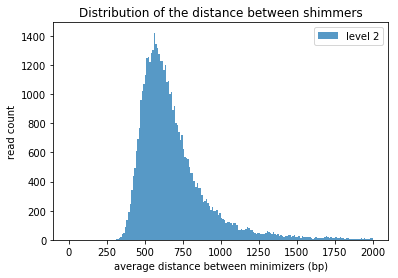

In [79]:

h_L2=plt.hist([x[1] for x in shimmer_count_L2], 
              bins=200, range=(0, 2000), alpha=0.75)
plt.xlabel("average distance between minimizers (bp)")
plt.ylabel("read count")
plt.legend( ("level 2",) )
plt.title("Distribution of the distance between shimmers")
print("mean distance:", np.mean([x[1] for x in shimmer_count_L2]) )
print("median distance:", np.median([x[1] for x in shimmer_count_L2]) )

In [70]:
k_count = []
for rid in all_rids[:50000]:
    if rid not in mmer_index_L2:
        continue
    shimmers_L2, kset_L2 = get_shimmers_for_read(rid, mmer_index_L2, py_mmer_L2)
    if len(shimmers_L2) < 2:
        continue
    k_count.append( (np.mean([c[-1] for c in shimmers_L2]), rid ) )

k_count.sort()
k_count[-1]

(229.0, 8190)

mean count: 79.56188576576095
median count: 77.73333333333333


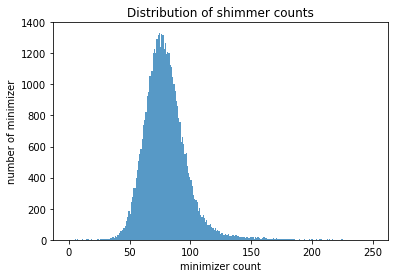

In [80]:
plt.hist( [c[0] for c in k_count], 
         bins=250, range=(0,250), alpha=0.75 );
plt.xlabel("minimizer count");
plt.ylabel("number of minimizer");
plt.title("Distribution of shimmer counts")
print("mean count:", np.mean([c[0] for c in k_count]) )
print("median count:", np.median([c[0] for c in k_count]) )

In [53]:
nread_ovlp = []
for rid in all_rids[:50000]:
    if rid not in mmer_index_L2:
        continue
    shimmers_L2, kset_L2 = get_shimmers_for_read(rid, mmer_index_L2, py_mmer_L2, mc_h=240)
    if len(shimmers_L2) < 2:
        continue
    rids = set()
    n0 = shimmers_L2[0]
    for n1 in shimmers_L2[1:]:
        v = shimmer_ffi.new("mp256_v *")
        shimmer4py.get_shimmer_hits(v, py_mmer_L2, n0[4], 16)
        for i in range(v.n):
            if  (v.a[i].x1 >> 8) == n1[4]:
                rids.add(v.a[i].y0 >> 32)
        n0 = n1
    nread_ovlp.append(len(rids))

mean count: 52.091704599779675
median count: 50.0


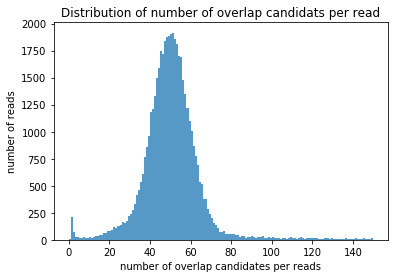

In [81]:
plt.hist(nread_ovlp, 
         bins=150, range=(0,150), alpha=0.75);
plt.xlabel("number of overlap candidates per reads");
plt.ylabel("number of reads");
plt.title("Distribution of number of overlap candidats per read")
print("mean count:", np.mean(nread_ovlp ))
print("median count:", np.median(nread_ovlp) )

In [59]:
nread=len(all_rids[:50000])
print("total reads sampled:", nread)
print("total number of overlap candidates:", np.sum(nread_ovlp))
print("number of candidates per read:", np.sum(nread_ovlp)/nread)

total reads sampled: 50000
total number of read candidates: 2506184
number of candidates per read: 50.12368
